# Forecast number of headcount daily

## Data Processing

### Read data

In [100]:
from pandas import read_csv

data = read_csv('../input/miami-mapper/hourly.csv', na_filter=False)

### Drop first day and last day

In [102]:
data.drop([0, len(data) - 1], inplace=True)

### Standardize data

In [103]:
data['count'] = data['MAC']
mean = data['MAC'].mean()
std = data['MAC'].std()
data['MAC'] = (data['MAC'] - mean) / std

### Size of history in days

In [104]:
size_h = 48

### Index of target days in break period

In [105]:
br = [index for index in data.index[data['break']].tolist() if index >= size_h]

### Index of target days not in break period

In [106]:
not_br = [index for index in data.index[data['break'] == False].tolist() if index >= size_h]

### Seperate features and target

In [107]:
from numpy import array

def resh(data):
    return data.reshape(data.shape[0], size_h, 1)

def seperate(list):
    x = []
    y = []
    for index in list:
        x.append(data['MAC'][index - size_h : index])
        y.append(data['MAC'][index])
    return resh(array(x)), array(y)

### Data in break period

In [108]:
x_br, y_br = seperate(br)

### Data not in break period

In [109]:
x_not, y_not = seperate(not_br)

## Design models using tensorflow keras

In [156]:
from tensorflow.keras.layers import Input, LSTM, Dense, PReLU
from tensorflow.keras.models import Sequential

# shape of output
sh = 32
# optimizer
optimizer = 'nadam'
# loss function
f = 'mse'

def build():
    model = Sequential()
    model.add(LSTM(sh, input_shape=(size_h, 1))) # Long short-term memory
    model.add(Dense(sh, activation='linear')) # Dense
    model.add(PReLU()) # activation for previous dense layer
    model.add(Dense(1, activation='linear')) # output layer
    model.compile(optimizer=optimizer, loss=f)
    return model

### Build models

In [157]:
model_br = build()
model_not = build()

## Train model

### Hyperparameters

In [158]:
# numbers of epoch
no = 75
# test set size
size = 0.1

### Visualize training losses

In [159]:
import matplotlib.pyplot as plt

def pl(track):
    loss = track.history['loss']
    val_loss = track.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.show()

Train on 172 samples, validate on 20 samples
Epoch 1/75
172/172 - 3s - loss: 0.4632 - val_loss: 0.3251
Epoch 2/75
172/172 - 0s - loss: 0.3322 - val_loss: 0.2304
Epoch 3/75
172/172 - 0s - loss: 0.2316 - val_loss: 0.1134
Epoch 4/75
172/172 - 0s - loss: 0.1064 - val_loss: 0.0210
Epoch 5/75
172/172 - 0s - loss: 0.0376 - val_loss: 0.0303
Epoch 6/75
172/172 - 0s - loss: 0.0310 - val_loss: 0.0243
Epoch 7/75
172/172 - 0s - loss: 0.0262 - val_loss: 0.0194
Epoch 8/75
172/172 - 0s - loss: 0.0226 - val_loss: 0.0180
Epoch 9/75
172/172 - 0s - loss: 0.0195 - val_loss: 0.0186
Epoch 10/75
172/172 - 0s - loss: 0.0167 - val_loss: 0.0164
Epoch 11/75
172/172 - 0s - loss: 0.0140 - val_loss: 0.0156
Epoch 12/75
172/172 - 0s - loss: 0.0120 - val_loss: 0.0136
Epoch 13/75
172/172 - 0s - loss: 0.0106 - val_loss: 0.0155
Epoch 14/75
172/172 - 0s - loss: 0.0091 - val_loss: 0.0147
Epoch 15/75
172/172 - 0s - loss: 0.0082 - val_loss: 0.0129
Epoch 16/75
172/172 - 0s - loss: 0.0076 - val_loss: 0.0112
Epoch 17/75
172/172 

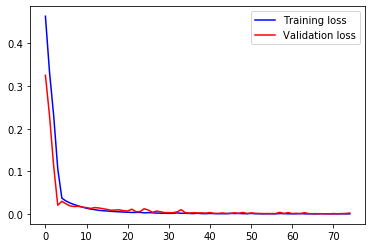

In [160]:
track = model_br.fit(x_br, y_br, epochs=no, verbose=2, validation_split=size, shuffle=True)
pl(track)

### Not in break period

Train on 2657 samples, validate on 296 samples
Epoch 1/75
2657/2657 - 4s - loss: 0.3143 - val_loss: 0.0680
Epoch 2/75
2657/2657 - 1s - loss: 0.0267 - val_loss: 0.0521
Epoch 3/75
2657/2657 - 1s - loss: 0.0118 - val_loss: 0.0089
Epoch 4/75
2657/2657 - 1s - loss: 0.0052 - val_loss: 0.0061
Epoch 5/75
2657/2657 - 1s - loss: 0.0024 - val_loss: 0.0074
Epoch 6/75
2657/2657 - 1s - loss: 0.0015 - val_loss: 3.0526e-04
Epoch 7/75
2657/2657 - 1s - loss: 0.0010 - val_loss: 0.0013
Epoch 8/75
2657/2657 - 1s - loss: 4.5986e-04 - val_loss: 4.6840e-04
Epoch 9/75
2657/2657 - 1s - loss: 8.1652e-04 - val_loss: 0.0209
Epoch 10/75
2657/2657 - 1s - loss: 9.3732e-04 - val_loss: 2.7963e-04
Epoch 11/75
2657/2657 - 1s - loss: 4.7056e-04 - val_loss: 5.9646e-04
Epoch 12/75
2657/2657 - 1s - loss: 4.5157e-04 - val_loss: 9.8022e-04
Epoch 13/75
2657/2657 - 1s - loss: 4.7225e-04 - val_loss: 0.0025
Epoch 14/75
2657/2657 - 1s - loss: 4.6560e-04 - val_loss: 1.4583e-04
Epoch 15/75
2657/2657 - 1s - loss: 3.9946e-04 - val_loss

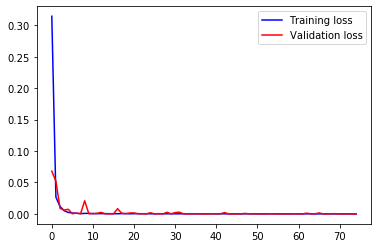

In [161]:
track = model_not.fit(x_not, y_not, epochs=no, verbose=2, validation_split=size, shuffle=True)
pl(track)

### Save weights

In [162]:
model_br.save_weights('br.h5')
model_not.save_weights('not.h5')

## Evaluate performance

### Cross validation

In [164]:
from sklearn.model_selection import KFold
from math import sqrt

cv = KFold(n_splits=10, shuffle=True)

# number of epochs
no = 40

def cross_valid(x, y):
    score = 0
    for train, test in cv.split(x, y):    
        model = build()
        model.fit(x[train], y[train], epochs=no, verbose=0, shuffle=True)
        score += sqrt(model.evaluate(x[test], y[test]))
    return score / 10

### In break period

In [165]:
print(cross_valid(x_br, y_br) * std)

19/19 [==============================] - 0s 20ms/sample - loss: 0.0011
21.253515484511315


### Not in break period

In [166]:
print(cross_valid(x_not, y_not) * std)

295/295 [==============================] - 0s 1ms/sample - loss: 1.9945e-04
12.645673450497211


## Visulization

### Convert to date time object

In [140]:
from pandas import to_datetime

data['time'] = to_datetime(data['time'], infer_datetime_format=True)

### Prediction

In [133]:
from math import nan

prediction = []
for index in range(len(data)):
    if index < size_h:
        prediction.append(nan)
    else:
        x = array(data['MAC'][index - size_h : index]).reshape(1, size_h, 1)
        if data['break'][index]:
            prediction.append(model_br.predict(x) * std + mean)
        else:
            prediction.append(model_not.predict(x) * std + mean)
data['prediction'] = prediction

### Predict next day based on last 14 days

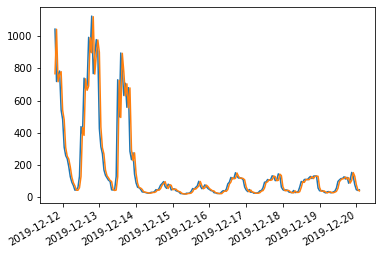

In [155]:
fig, ax = plt.subplots()
ax.plot_date(data['time'][1700:1900], data[['count', 'prediction']][1700:1900], '-')
fig.autofmt_xdate()
plt.show()